# Ideas

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import re
import logging

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

from time import time

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, TimestampType

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.metrics.metrics import Metrics
from sponge_bob_magic.validation_schemes import ValidationSchemes

In [5]:
# Отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [6]:
spark_memory = "2g"
spark_cores = "30"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

In [7]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [8]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Основные данные и пути

In [9]:
path_data = '/datascc/share/ideas_data'
path_log1 = os.path.join(path_data, '2018.csv')
path_log2 = os.path.join(path_data, '2017.csv')
path_log = os.path.join(path_data, "data.csv")
path_checkpoints = '../data/checkpoints'

In [10]:
spark.sparkContext.setCheckpointDir(path_checkpoints)

In [15]:
# %%time

# user_item_data = (
#     pd.read_csv(
#         path_log1,
#         sep=";",
#         usecols=["id_project", "user_id", "type"],
#         dtype=str
#     ).append(
#         pd.read_csv(
#             path_log2,
#             sep=";",
#             usecols=["id_project", "user_id", "type"],
#             dtype=str
#         )
#     ).query("type in ('Pim::IdeaBestPracticeVote', 'Pim::IdeaResourceVote', 'Pim::IdeaVote')")
#     .drop(columns=["type"])
#     .rename(columns={"user_id": "user_id", "id_project": "item_id"})
# )
# user_item_data.to_csv(path_log, index=False)

CPU times: user 13.3 s, sys: 1.09 s, total: 14.4 s
Wall time: 14.6 s


In [16]:
%%time

log = pd.read_csv(path_log)

CPU times: user 1.09 s, sys: 140 ms, total: 1.23 s
Wall time: 1.23 s


In [17]:
log.head()

,item_id,user_id
0,252605,97636
1,235144,65714
2,240366,144702
3,258534,55067
4,258533,55067


In [18]:
log.nunique()

item_id    128558
user_id    71343 
dtype: int64

In [19]:
len(log)

4691248

## Подготовка данных

In [11]:
dp = DataPreparator(spark)

In [12]:
df = dp.transform_log(
    path=path_log,
    format_type="csv",
    schema=StructType([
        StructField("user_id", StringType()),
        StructField("item_id", StringType())
    ]),
    columns_names={
        "user_id": "user_id",
        "item_id": "item_id"
    }
).cache()

In [13]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- context: string (nullable = false)
 |-- relevance: float (nullable = false)



In [14]:
df.show(3)

+-------+-------+-------------------+----------+---------+
|user_id|item_id|          timestamp|   context|relevance|
+-------+-------+-------------------+----------+---------+
|item_id|user_id|1999-05-01 00:00:00|no_context|      1.0|
| 252605|  97636|1999-05-01 00:00:00|no_context|      1.0|
| 235144|  65714|1999-05-01 00:00:00|no_context|      1.0|
+-------+-------+-------------------+----------+---------+
only showing top 3 rows



## Рекомендации популярных объектов

In [15]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [16]:
%%time

pr.fit(
    log=df,
    user_features=None,
    item_features=None,
    path=None
)

15-Oct-19 17:02:02, root, DEBUG: Среднее количество items у каждого user: 37.0


CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 5.88 s


In [17]:
%%time

recs = pr.predict(
    k=100,
    users=None,
    items=None,
    context='no_context',
    log=df,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
)

15-Oct-19 17:02:04, root, DEBUG: Проверка датафреймов
15-Oct-19 17:02:04, root, DEBUG: Выделение дефолтных юзеров
15-Oct-19 17:02:04, root, DEBUG: Выделение дефолтных айтемов
15-Oct-19 17:02:11, root, DEBUG: Количество items после фильтрации: 137
15-Oct-19 17:02:16, root, DEBUG: Длина recs: 17612583


CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 35.6 s


In [18]:
recs.show(5)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2903| 100010|no_context|0.010434960924052421|
|  37337| 100010|no_context|  0.0083353068660393|
|  57335| 100010|no_context|0.006834214086696315|
|   2962| 100010|no_context|0.006792221005536053|
|  65750| 100010|no_context|0.006021210982405751|
+-------+-------+----------+--------------------+
only showing top 5 rows



In [21]:
%%time

metric = Metrics.hit_rate_at_k(recs, df, k=100)
metric

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 37.9 s


0.0004978259009482028

## Сценарий с популярной моделью

In [22]:
df_short = df.limit(10)
df_short.checkpoint()

DataFrame[user_id: string, item_id: string, timestamp: timestamp, context: string, relevance: float]

In [34]:
avg_num_users = (
    df
    .select('user_id', 'item_id')
    .groupBy('item_id')
    .count()
    .select(sf.mean(sf.col('count')).alias('mean'))
    .collect()[0]['mean']
)

avg_num_users

65.75534032294236

In [35]:
popular_scenario = PopularScenario(spark)
popular_params_grid = {'alpha': (0, 65), 'beta': (0, 65)}
# popular_scenario.seed = 9876

In [46]:
%%time

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=50, context='no_context',
    to_filter_seen_items=True,
    n_trials=10, n_jobs=1,
    how_to_split='randomly'
)

16-Oct-19 11:55:26, root, DEBUG: Деление на трейн и тест
16-Oct-19 11:55:34, root, DEBUG: Размер трейна:      3283758
16-Oct-19 11:55:34, root, DEBUG: Размер теста_инпут: 3283758
16-Oct-19 11:55:36, root, DEBUG: Размер теста:       1402125
16-Oct-19 11:55:47, root, DEBUG: Среднее количество items у каждого user: 26.0
16-Oct-19 11:55:48, root, DEBUG: Начало оптимизации параметров
16-Oct-19 11:55:48, root, DEBUG: Предикт модели в оптимизации
16-Oct-19 11:55:48, root, DEBUG: Проверка датафреймов
16-Oct-19 11:55:58, root, DEBUG: Количество items после фильтрации: 76
16-Oct-19 11:56:06, root, DEBUG: Длина recs: 9428788
16-Oct-19 11:56:26, root, DEBUG: Подсчет метрики в оптимизации
16-Oct-19 11:57:08, root, DEBUG: Метрика и параметры: (0.006891659882479063, {'alpha': 1, 'beta': 61})
[I 2019-10-16 11:57:08,215] Finished trial#0 resulted in value: 0.006891659882479063. Current best value is 0.006891659882479063 with parameters: {'alpha': 1, 'beta': 61}.
16-Oct-19 11:57:08, root, DEBUG: Предикт

CPU times: user 1.3 s, sys: 172 ms, total: 1.48 s
Wall time: 14min 22s


In [47]:
best_params

{'alpha': 1, 'beta': 61}

In [ ]:
results = popular_scenario.study.trials_dataframe()

results.head()

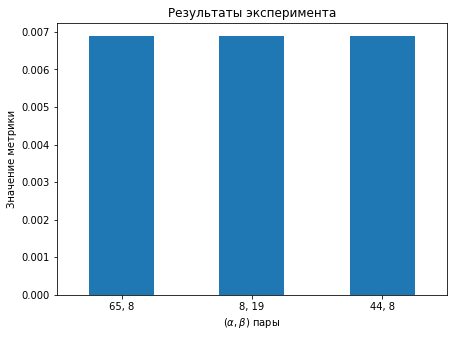

In [48]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты эксперимента')

    plt.show()
    

plot_result_value(results)

In [40]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

16-Oct-19 11:32:21, root, DEBUG: Среднее количество items у каждого user: 37.0
16-Oct-19 11:32:22, root, DEBUG: Проверка датафреймов
16-Oct-19 11:32:22, root, DEBUG: Выделение дефолтных юзеров
16-Oct-19 11:32:22, root, DEBUG: Выделение дефолтных айтемов
16-Oct-19 11:32:28, root, DEBUG: Количество items после фильтрации: 47
16-Oct-19 11:32:32, root, DEBUG: Длина recs: 6042273


CPU times: user 40 ms, sys: 16 ms, total: 56 ms
Wall time: 25.1 s


In [41]:
best_recs.show(10)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2903| 100010|no_context|0.010437023584181715|
|  37337| 100010|no_context|0.008337383400692348|
|  57335| 100010|no_context|0.006836300540577412|
|   2962| 100010|no_context|0.006794307736907625|
|  65750| 100010|no_context|0.006023302808615133|
|  32146| 100010|no_context| 0.00594954895039307|
|  71934| 100010|no_context|0.004986272403267339|
|  58247| 100010|no_context|0.004456139902116267|
|  33182| 100010|no_context|0.004297974113674732|
|  32858| 100010|no_context|0.003826461008509...|
+-------+-------+----------+--------------------+
only showing top 10 rows

